In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/4_deep_Q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train

### Run locally

In [3]:

from rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train

### Objective
In order to tackle difficult problems (of large size and complexity), we introduce an deep Q learning.

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
sns.set_style("darkgrid")

In [5]:
env = gym.make('CartPole-v0')

In [6]:
time_steps = 100
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    env.render()
    sleep(0.04)
env.close()

# deep Q-learning

When the state space is continous. It is necessary to have a function for the Q value. A common way to represent and update this function is to use parametric function (as neural network).
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we learn and update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q_\theta(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$
2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In other words, if we played $a$ (second action) in $s$, and we obseved $r$ and $s'$, our target will be (assuming we have 3 actions):

$\begin{aligned}
y_0 =& Q(s,a,\theta)_0\\
y_1 =&R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)\\
y_2 =&Q(s,a,\theta)_2
\end{aligned}$

And our loss:

$L(\theta) = (R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta) - Q(s,a,\theta)_1)^2$

In [7]:
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='linear')(x)
    model = Model(inputs=input_state, outputs=x)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

In [8]:
#TODO: write deep Q learning update
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        pass #complete here

In [9]:
#Done: write deep Q learning update
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        predicted_Q_nexts = self.model.predict(next_state.reshape(1, -1))[0]
        target = self.model.predict(current_state.reshape(1, -1))[0]
        if done is True:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(predicted_Q_nexts)
        self.model.train_on_batch(current_state.reshape(1, -1), target.reshape(1, -1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 34.0
episode: 1 - cum reward 12.0
episode: 2 - cum reward 11.0
episode: 3 - cum reward 8.0
episode: 4 - cum reward 10.0
episode: 5 - cum reward 10.0
epi

episode: 229 - cum reward 60.0
episode: 230 - cum reward 120.0
episode: 231 - cum reward 200.0
episode: 232 - cum reward 200.0
episode: 233 - cum reward 200.0
episode: 234 - cum reward 200.0
episode: 235 - cum reward 15.0
episode: 236 - cum reward 200.0
episode: 237 - cum reward 31.0
episode: 238 - cum reward 15.0
episode: 239 - cum reward 158.0
episode: 240 - cum reward 200.0
episode: 241 - cum reward 200.0
episode: 242 - cum reward 12.0
episode: 243 - cum reward 200.0
episode: 244 - cum reward 15.0
episode: 245 - cum reward 200.0
episode: 246 - cum reward 147.0
episode: 247 - cum reward 9.0
episode: 248 - cum reward 13.0
episode: 249 - cum reward 200.0
episode: 250 - cum reward 200.0
episode: 251 - cum reward 18.0
episode: 252 - cum reward 15.0
episode: 253 - cum reward 200.0
episode: 254 - cum reward 200.0
episode: 255 - cum reward 190.0
episode: 256 - cum reward 101.0
episode: 257 - cum reward 14.0
episode: 258 - cum reward 21.0
episode: 259 - cum reward 200.0
episode: 260 - cum re

Text(0.5, 1.0, 'cumulative reward per episode - deep_q_agent')

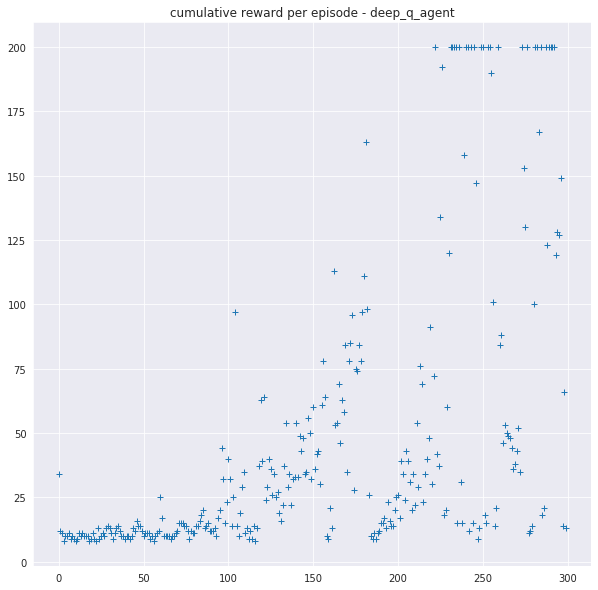

In [10]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = DeepQAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - deep_q_agent')

### Experience replay

$L_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s, a; \theta_i)\right)^2 \right]$

In [11]:
#TODO: write The function replay that return bacth from memory
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
    def replay(self, batch_size):
        pass #complete here
    
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

In [12]:
#Done: write The function replay that return bacth from memory
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
    
    # easy loop way
    #def replay(self, batch_size):
    #    x_batch =  np.zeros((batch_size, self.state_size))
    #    y_batch =  np.zeros((batch_size, self.action_size))
    #    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    #    for i, (state, action, reward, next_state, done) in enumerate(minibatch):
    #        target = self.model.predict(state.reshape(1,-1))[0]
    #        if done:
    #            target[action] = reward
    #        else:
    #            target[action] = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1,-1)))
    #        x_batch[i] = state
    #        y_batch[i] = target
    #    return x_batch, y_batch
    
    #optimize way
    def replay(self, batch_size):
        minibatch = np.array(random.sample(self.memory, min(len(self.memory), batch_size)))
        states = np.vstack(np.array(minibatch)[:,0])
        actions = np.array(minibatch)[:,1].astype(int)
        rewards = np.array(minibatch)[:,2]
        next_states = np.vstack(np.array(minibatch)[:,3])
        dones = np.array(minibatch)[:,4]
        targets = self.model.predict(states)
        targets_next = self.model.predict(next_states)
        targets[np.arange(actions.size),actions] = rewards + (1 - dones) * self.gamma * np.max(targets_next, axis=1)
        return states, targets
    
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 22.0
episode: 1 - cum reward 16.0
episode: 2 - cum reward 10.0
episode: 3 - cum reward 16.0
episode: 4 - cum reward 23.0
episode: 5 - cum reward 19.0
episode: 6 - cum reward 24.0
episode: 7 - cum reward 25.0
episode: 8 - cum reward

Text(0.5, 1.0, 'cumulative reward per episode - memory_deep_q_agent')

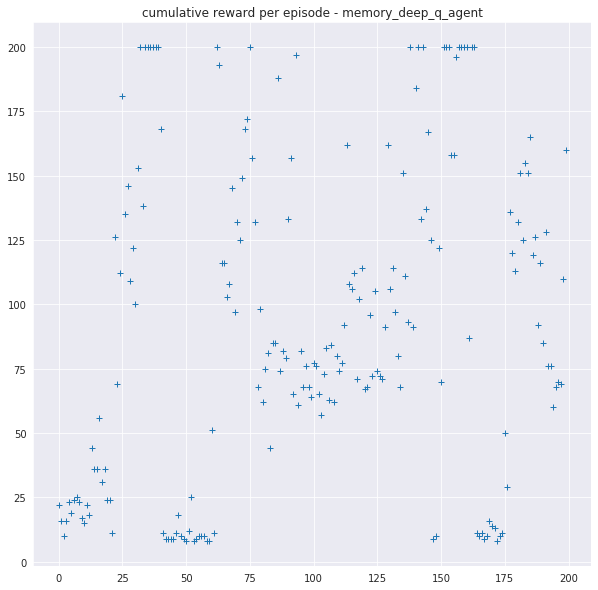

In [13]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)

q_agent = DeepQAgent_experience_replay(env, model)
rewards = run_experiment_episode_train(env, q_agent, 200)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - memory_deep_q_agent')

# Other improvments

### epsilon decay
Decay how random you take an action

### clipping reward
$Q(s,a):=Q(s,a)+\alpha(clip(r+\gamma \arg\max(Q(s',a'))-Q(s,a), -1, 1))$

### clipping loss
tf.keras.losses.Huber(delta=1.)

### Double Q learning

DQN: A reinforcement learning algorithm that combines Q-Learning with deep neural networks to let RL work for complex, high-dimensional environments, like video games, or robotics.
Double Q Learning: Corrects the stock DQN algorithm’s tendency to sometimes overestimate the values tied to specific actions.
Prioritized Replay: Extends DQN’s experience replay function by learning to replay memories where the real reward significantly diverges from the expected reward, letting the agent adjust itself in response to developing incorrect assumptions.
Dueling DQN: Splits the neural network into two — one learns to provide an estimate of the value at every timestep, and the other calculates potential advantages of each action, and the two are combined for a single action-advantage Q function.